# Time-sequence modelling of von Mises distributions
Libby Zhang

Estimation of angular and other periodic quantities requires distinct techniques from those designed for Euclidean quantities. While standard estimation techniques can be modified to address the issues arising from circular quantities, these modifications can be tedious, error prone, and yield suboptimal results due to violation of certain assumptions. Estimation techniques based on directional statistics, on the other hand, can correctly perform circular operations and use the proper manifold.

Circular statistics are of relevance in fields such as of biology, meterology, geosciences, and robotics. In the project below, we will work specifically with circular distributions ($\mathbb{S} \in \mathbb{R^2}$) and use the motivating example of tracking a rotary joint of a robotic arm over time.

The formulations and equations in this project are based on the following paper:

    G. Kurz, I. Gilitschenski, and U. D. Hanebeck, “Recursive Nonlinear Filtering for Angular Data Based on Circular Distributions,” in Proceedings of the 2013 American Control Conference (ACC 2013), Washington D. C., USA, Jun. 2013.

This paper develops a filter based on circular statistics for nonlinear systems with additive process noise, and identity measurement with additive measurement noise.
\begin{align*}
    x_{k+1} &= a_k(x_k) + w_k &\textrm{ mod } 2\pi \\
    z_{k} &= x_k + v_k &\textrm{ mod } 2\pi
\end{align*}
with state $x_k \in \mathbb{S}$,
    state evolution function $a_k: \mathbb{S} \rightarrow \mathbb{S}$,
    process noise $w_k \in \mathbb{S}$,
    observation $z_k \in \mathbb{S}$,
    and observation noise $v_k \in \mathbb{S}$.
    
As will be discussed later (in the section titled "Operations on circular distributions"), the authors of the paper chose to represent state and observation variables with a wrapped normal distribution, to facilitate the consideration of additive noise. This is because a wrapped normal distribution is closed under convolution and retains the additive noise properties of a (unwrapped) normal distribution. Von Mises distributions, however, are not closed under convolution, but approximations based on taking an intermediate wrapped normal distribution exists and are fairly satisfactory.

While there exists literature on how to implement functions and attributes for wrapped normal distributions (see [KGH 2014a] and [KGP 2017], no such Python packages are readily available to faciliate the visaulization and evaluation of these distributions. Von Mises distributions are also commonly used to approximate wrapped normal distributions, especially for small sample sizes. So, in the following implementation, I will assume that all model variables are distributed according to a von Mises distribution ($p=2$) unless otherwise noted. I will continue to make comments on wrapped normal distributions.

In [83]:
import numpy as np

from scipy.stats import vonmises            # von Mises (M2) continue random variable
                                            # Note that this object uses angular representation (-pi <= x <= pi), and not vector representation (|x|=1, x \in S^{p-1} \subset R^p)
from scipy.special import iv as bessel_iv   # Modified Bessel function of the first kind of real order.

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
import matplotlib.gridspec as gridspec

from tqdm import tqdm

# Circular distributions

We will focus our discussion on circular distributions, $\mathbb{S} \subset \mathbb{R}^2$.
Directional statistics in higher $p$-dimensional spaces, $\mathbb{S}^{p-1} \subset \mathbb{R}^p$ can easily be generalized from circular $p=2$ case. See [MJ 1998] for a systematic treatment.
Many circular distributions arise from wrapping a distribution from the line onto a circle, or radially projecting distributions from a plane onto the circle, or conditioning distributions in Euclidean space $\mathbb{R}^2$ to conform with the topology of the spherical subset $\mathbb{S}^p$.

The wrapped Normal (WN) and von Mises (vM) distributions are among the key models in circular statistics. There relation to the normal distribution (univariate for WN and bivariate for VM) are described in the figure below (source: [KGH 2014]). With $x\in\mathbb{S}$, $\mu\in\mathbb{S}$, and non-negative variance/concentration parameters, their respective pdfs are given by:

\begin{align*}
    \textrm{WN}(x;\, \mu, \sigma^2) &=
        \frac{1}{\sqrt{2\pi \sigma^2}} \sum_{k=-\infty}^\infty \exp \Big(- \frac{(x-\mu + 2\pi\kappa)^2}{2\sigma^2} \Big) \\
    \textrm{vM}(x;\, \mu, \kappa) &=
        \frac{1}{2\pi I_0(\kappa)}\, \exp \big(\kappa cos(x-\mu) \big)
\end{align*}

<center><img src='circular_distributions.png' style='width: 1000px'><\center>

In [2]:
mu = 0.3*np.pi  # Mean direction [radians]
kappa = 10        # Concentration parameter, [0, inf)
X = vonmises(kappa, mu)

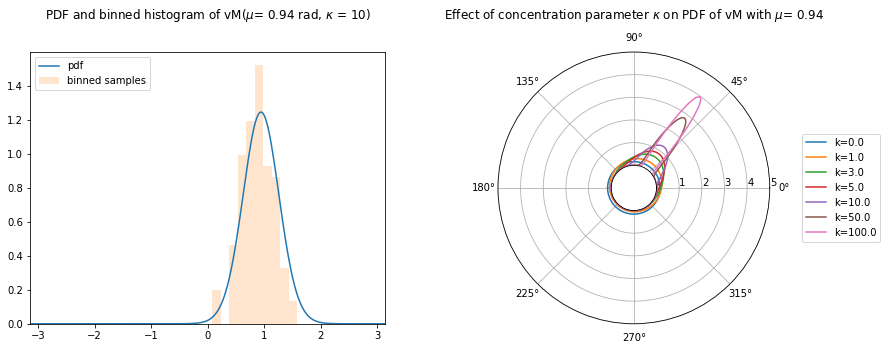

In [3]:
angles = np.linspace(-np.pi, np.pi, num=250)

fig = plt.figure(figsize=(14,5))

# Plot analytical and sampled distribution on rectangular coordinates
ax = fig.add_subplot(121)
ax.plot(angles,X.pdf(angles), label ='pdf')
ax.hist(X.rvs(size=100), density=True, histtype = 'stepfilled', alpha=0.2, label = 'binned samples')
ax.set_xlim([-np.pi, np.pi])
ax.set_title('PDF and binned histogram of vM($\mu$= %.2f rad, $\kappa$ = %d)' %(mu, kappa), y = 1.1)
ax.legend()

# Plot analytical distributions for different kappa values on polar coordinates
ax = fig.add_subplot(122, projection = 'polar')
ksweep = [1e-3, 1, 3, 5, 10, 50, 100]
for k in ksweep:
    ax.plot(angles, vonmises.pdf(angles, k, mu), label = 'k=%.1f'%k)

ax.set_rorigin(-1)
ax.set_rgrids(np.arange(0,ax.get_ylim()[-1]+1))
ax.set_rlabel_position(0)
ax.set_title('Effect of concentration parameter $\kappa$ on PDF of vM with $\mu$= %.2f' %(mu), y=1.1)
ax.legend(loc='center left', bbox_to_anchor=[1.1,0.5])

# Circular Moment Matching

The n-th circular (or trignometric) moment of a random variable $x$ with pdf $f(\cdot)$ is given by
    $$ m_n = \mathbb{E}[e^{inx}] = \int_0^{2\pi}e^{inx} f(x)\,\mathrm{d}x$$
Note that the circular moments are complex numbers, so they each hav two degrees of freedom.

The WN and VM distributions are uniquely defined by their first circular moment, which contains information about the mean direction $\textrm{arg } m_1 = \mu$ and the mean resultant length $|m_1| = \rho$. The mean resultant length is a key measure of dispersion and can be used to calculation the standard measures of dispersion for different circular distributions, such as the variance in a wrapped normal distribution and the concentration in a vM distribution.
\begin{align*}
    \textrm{arg } m_1 &= \tan^{-1}\Big(\frac{\mathrm{Im}\, m_1}{\mathrm{Re}\, m_1}\Big) \\
    |m_1| &= \sqrt{(\mathrm{Re}\, m_1)^2 + (\mathrm{Im}\, m_1)^2}
\end{align*}

Since these distributions are both uniquely defined by their first circular moment, moment matching of the first circular moment can be used to convert between the distributions. For a given first moment $m_1$,
\begin{align*}
    WN(\mu,\;& \sigma^2 = -2 \log \rho) \\
    VM(\mu,\;& \kappa = A_2^{-1}(\rho))
\end{align*}
where $A_d(\kappa) = \bar{R} = \frac{I_{d/2}(\kappa)}{I_{d/2-1}(\kappa)}$ is the ratio of Bessel functions of first kind used to link mean resultant lengths and concentration in a von Mises distribution.

Note that WN and VM distributions with equal first moments differ significantly in their higher order moments.

In [131]:
# Functions for vMF functions of dimension p (denoted as M_p)
# Common dimensions are M_2 (von MIses distribution, defined on a circle) and M_3 (Fisher distribution, defined on a sphere)

def Ap(kappa, p=3):
    """
    Calculates the ratio of Bessel functions of the first kind, for use with a M_p distribution
    Parameters
        kappa: scalar or array_like (N, ), [0, \inf)
            Concentration parameter(s) of the M_p distribution
        p: integer, >=2
            Dimensionality of the hypersphere, S^{p-1} on which the M_p distribution is defined
    Returns
        rho: scalar or array_like(N, ), [0,1]
            Mean resultant length (a measure of dispersion) of the M_p distribution
    """
    A1 = bessel_iv(p/2., kappa)
    A0 = bessel_iv(p/2.-1 , kappa)
    return np.divide(A1, A0, out=np.zeros_like(A1), where= (A0!=0))

def Ap_inv(rbar, p=3):
    """
    Calculates inverse of Afunc, e.g. to estimate concentration parameter kappa of M_p distribution
    Parameters
        rbar: scalar or array_like (N, ), [0, \inf)
            Sample mean resultant length of samples drawn from a M_p distribution
        p: integer, >=2
            Dimensionality of the hypersphere, S^{p-1} on which the M_p distribution is defined
    Returns
        khat: scalar or array_like(N, ), [0,1]
            Approximated concentration parameter of the M_p distribution
    """
    
    # Create persistent variables Ksweep and Rho to store array of Ap values
    # This avoids re-calculating ratio for a given dimension at each call
    if 'Rho' not in Ap_inv.__dict__:
        print('Creating Ap_inv.Rho for dimension %d' %p)
        Ap_inv.Ksweep = np.logspace(-2, 2, num=500) # [0.01, 100.0]
        Ap_inv.Rho = {}
        Ap_inv.Rho[p] = Ap(Ap_inv.Ksweep, p)
    elif p not in Ap_inv.Rho:
        print('Creating Ap_inv.Rho for dimension %d' %p)
        Ap_inv.Rho[p] = Ap(Ap_inv.Ksweep, p)
    
    return np.interp(rbar, Ap_inv.Rho[p], Ap_inv.Ksweep)

def vmf_moment(params, n=1):
    """
    Calculates the nth circular moment of a M_p distribution with parameters mu and kappa
    Parameters
        params: (mu, kappa) tuple
            mu: scalar or array_like (..., p-1),
                Mean angle, in radians
            kappa: scalar or array_like (...,)
                Concentration parameter
        n : int
            nth circular moment to evaluate
    Returns
        m : complex number
            nth circular moment of vMF distribution
    """
    mu, kappa = params
    
    # Infer dimensionality from mean parameter
    # NOTE! Assuming mu is an polar coordinates (angular)
    # Need to modify if mu is an vector coordinates
    if isinstance(mu, float) or isinstance(mu, int):
        p = 2
    else:
        mu = np.array(mu)
        p = mu.shape[-1]+1 if mu.ndim > 1 else 2
        
    return np.exp(n*mu*1j) * Ap(kappa, p)

def vmf_params(m1):
    """
    Calculates the nth circular moment of a M_p distribution with parameters mu and kappa
    Parameters
        m1: complex
            First circular moment
    Returns
        params : (mu, kappa)
            Parameters of the M_2 distribution defined by the given first circular moment
    """
    return (np.angle(m1)%(2*np.pi), Ap_inv(np.abs(m1), p=2))

Text(0.5, 1.05, 'Mean resultant length $\\rho$ vs. concentration $\\kappa$ for $p=2$ vM distribution')

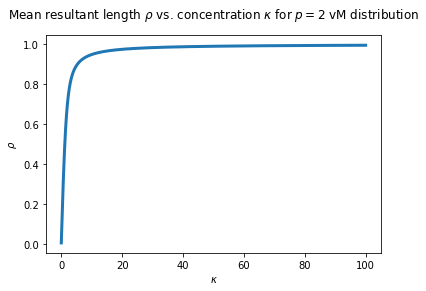

In [7]:
p = 2
ksweep = np.logspace(-2, 2, num=500) # [0.01, 100.0]
rho = Ap(ksweep, p)

plt.plot(ksweep, rho, lw =3)
plt.xlabel(r'$\kappa$'); plt.ylabel(r'$\rho$')
plt.title(r'Mean resultant length $\rho$ vs. concentration $\kappa$ for $p=2$ vM distribution', y=1.05)

# Operations on circular densities

## Convolution
Convolution of densities is important when considering additive noise. Given two independent circular random variables $x_1 \sim f_1(x_1)$ and $x_2 \sim f_2(x_2)$, then the $x = x_1 + x_2 \sim (f_1\ast f_2)(x) = \int_0^{2\pi} f_1(t)\,f_2(x-t)\mathrm{d}t$.

### Convolution of wrapped normal distributions
Wrapped normal distributions are closed under convolution, and
$$\textrm{WN}\big(\mu_1, \sigma_1^2\big)\ast \textrm{WN}\big(\mu_2, \sigma_2^2\big)
    =\textrm{WN}\big(\mu=(\mu_1 + \mu_2)\textrm{ mod } 2\pi, \sigma^2= \sigma_1^2 + \sigma_2^2\big)$$

### Convolution of von Mises distributions
von Mises distributions, on the other hand, are not closed under convolution. Several approximations have been made to address this, including the following given by Mardia and Jupp (Eqn. 3.5.44 ):
$$\textrm{vM}\big(\mu_1, \kappa_1\big)\ast \textrm{vM}\big(\mu_2, \kappa_2)\big)
    \approx\textrm{vM}\big(\mu=(\mu_1 + \mu_2)\textrm{ mod } 2\pi, \kappa=A_p^{-1}(A_p(\kappa_1)\cdot A_p(\kappa_2)\big)$$
In the context of moment matching between WN and vM distributions, this approximation can be understood as taking an intermediate WN distributions in order to perform the convolution.

### Convolution of circular distributions
In fact, [KGH 2016a] prove that the moments of a convolved density can be calculated purely based on the products of the original moments. [KGH 2016a] Lemma 3 states: Assume independent random variables $x_1\sim f_1, x_2 \sim f_2$ defined on the circle. For the sum $x=x_1 + x_2$, it holds
$$ \mathbb{E}\big[e^{inx}\big] = \mathbb{E}\big[e^{inx_1}\big]\cdot \mathbb{E}\big[e^{inx_2}\big]$$
The results for the convolution of the WN distribution and the approximate result of the convolution of vM distributions can be seen as special cases of this generalization.

In [132]:
def vmf_convolve(params1, params2):
    """
    Computes the sum of two independent VM densities. Equivalent to computing the approximate parameters
    by assuming an intermediate WN density found via moment matching:
        mu = (mu1 + mu2)%(2*np.pi)
        k = Ap_inv(Ap(k1, p=2)*Ap(k2, p=2), p=2)
    Parameters
        params1: (mu, kappa)
            Parameters of first von Mises distribution
        params2: (mu, kappa)
            Parameters of second von Mises distribution
    Returns
        params: (mu, kappa)
            Returns parameters of the resulting approximating von Mises distribution
    """
    m1 = vmf_moment(params1) * vmf_moment(params2)
    return vmf_params(m1)

Creating Ap_inv.Rho for dimension 2


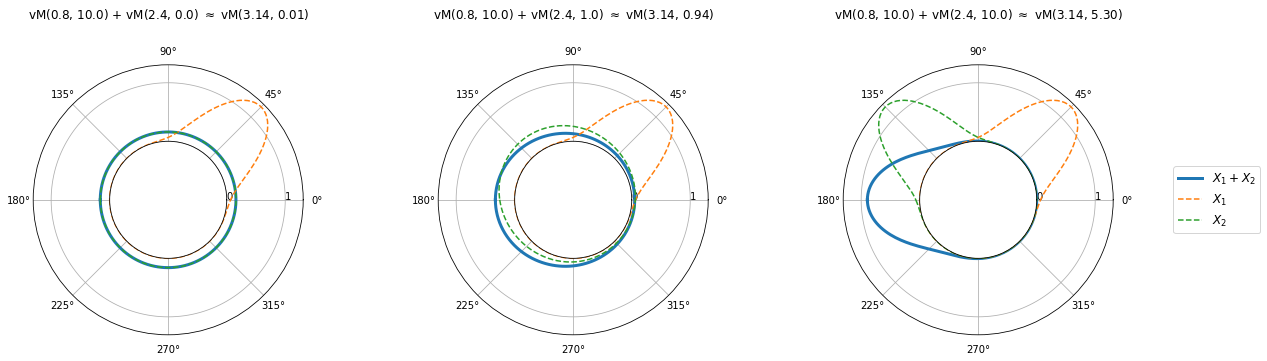

In [133]:
# Visualize product distribution as function of varying concentration parameter of the second distribution, f_2 (e.g. noise distribution)
params1 = (np.pi/4, 10)
params2_list = [(3*np.pi/4, 1e-3), (3*np.pi/4, 1), (3*np.pi/4, 10),]

# --------------------------------------------------------------------------------
def plot_vmf_convolution(params1, params2, ax):
    
    mu1, kappa1 = params1;
    mu2, kappa2 = params2
    (mu, kappa) = vmf_convolve(params1, params2) # Calculate parameters of convolved distribution
    
    angles = np.linspace(-np.pi, np.pi, num=250)
    ax.plot(angles, vonmises.pdf(angles, kappa, mu),   lw=3, label =r'$X_1 + X_2$')
    ax.plot(angles, vonmises.pdf(angles, kappa1, mu1), '--', label =r'$X_1$')
    ax.plot(angles, vonmises.pdf(angles, kappa2, mu2), '--', label =r'$X_2$')
    
    ax.set_rorigin(-1)
    ax.set_rgrids(np.arange(0,ax.get_ylim()[-1]+0.2))
    ax.set_rlabel_position(-np.pi/4)

    ax.set_title(r'vM(%.1f, %.1f) + vM(%.1f, %.1f) $\approx$ vM(%.2f, %.2f)' %(mu1, kappa1, mu2, kappa2, mu, kappa),y=1.15)
    return ax

# Subplot parameters
fig = plt.figure(figsize=(15,5))
r = 1; c = len(params2_list)

for i, params2 in enumerate(params2_list):
    ax = fig.add_subplot(r,c,i+1, projection='polar')
    ax = plot_vmf_convolution(params1, params2, ax)
 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.5)
ax.legend(loc='center left', bbox_to_anchor=[1.2,0.5], fontsize=12)

## Multiplication
Multiplication of densities is required to perform Bayesian inference.

Von Mises distributions are closed under multiplication and produce a product that can be renormalized to a proper pdf.
$$\textrm{vM}\big(\mu_1, \kappa_1\big)\cdot \textrm{vM}\big(\mu_2, \kappa_2\big)
    \propto\textrm{vM}\big(\mu= \textrm{arg } m_1, \kappa= |m_1|\big), \quad \textrm{with } m_1 = \kappa_1 e^{i\mu_1} + \kappa_2 e^{i\mu_2}$$
    
Multiplication of wrapped normal distributions are not closed under multiplications, but there are several methods to approximate this operation. These will not be explored here.

In [134]:
def vmf_multiply(params1, params2):
    """
    Computes the product of two independent VM densities
    Parameters
        params1: (mu, kappa)
            Parameters of first von Mises distribution
        params2: (mu, kappa)
            Parameters of second von Mises distribution
    Returns
        params: (mu, kappa)
            Returns parameters of the resulting von Mises distribution
    """
    mu1, k1 = params1
    mu2, k2 = params2
    
    m1 = k1*np.exp(mu1*1j) + k2*np.exp(mu2*1j)
    return (np.angle(m1)%(2*np.pi), np.abs(m1))

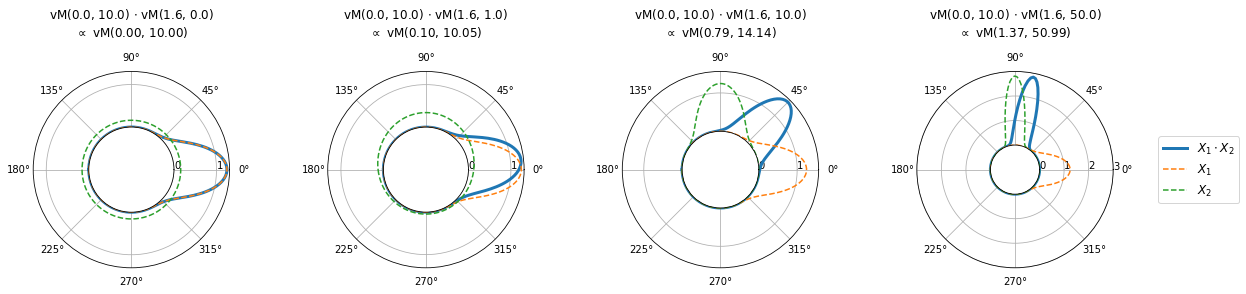

In [135]:
# Visualize product distribution as function of varying concentration parameter of the second distribution, f_2 (e.g. prior)
# As concentration of f_2 increases, the mean direction of the resulting distribution approaches the mean of f_2
params1 = (0, 10)
params2_list = [(np.pi/2, 1e-3), (np.pi/2, 1), (np.pi/2, 10), (np.pi/2, 50)]

# --------------------------------------------------------------------------------
def plot_vmf_multiplication(params1, params2, ax):
    mu1, kappa1 = params1; mu2, kappa2 = params2
    (mu, kappa) = vmf_multiply(params1, params2) # Calculate parameters of product distribution
    
    angles = np.linspace(-np.pi, np.pi, num=250)
    ax.plot(angles, vonmises.pdf(angles, kappa, mu),   lw=3, label =r'$X_1\cdot X_2$')
    ax.plot(angles, vonmises.pdf(angles, kappa1, mu1), '--', label =r'$X_1$')
    ax.plot(angles, vonmises.pdf(angles, kappa2, mu2), '--', label =r'$X_2$')
    
    ax.set_rorigin(-1)
    ax.set_rgrids(np.arange(0,ax.get_ylim()[-1]+0.2))
    ax.set_rlabel_position(-np.pi/4)

    ax.set_title(r'vM(%.1f, %.1f) $\cdot$ vM(%.1f, %.1f)'%(mu1, kappa1, mu2, kappa2) + '\n' + r'$\propto$ vM(%.2f, %.2f)' %(mu, kappa),y=1.15)
    return ax

# Subplot parameters
fig = plt.figure(figsize=(15,5))
r = 1; c = len(params2_list)

for i, params2 in enumerate(params2_list):
    ax = fig.add_subplot(r,c,i+1, projection='polar')
    ax = plot_vmf_multiplication(params1, params2, ax)
 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.5)
ax.legend(loc='center left', bbox_to_anchor=[1.2,0.5], fontsize=12)

## Deterministic sampling

Application of nonlinear functions to complex continuous functions, such as pdfs, is typically a computationally intensive task. Instead, discrete sample-based approximations of these continuous functions can be used to over come this limitation, because the nonlinear function can be applied to each sample individually. While stochastic sampling methods such as Monte Carlo can often very accurately capture the characteristics of a nonlinear function, these approaches often need large number of samples to achieve said accuracy. Deterministic sampling methods, when carefully designed, can similarly capture aspects of the nonlinear function with far fewer samples.
Determinstic sampling is used to progate continuous probability densities through nonlinear functions.

In the case of approximating pdfs, samples can be chosen to fit certain moments or otherwises optimally approximate the shape of the density. In the case of circular densities, a wrapped Dirac mixture distribution can be used.

### Wrapped Dirac mixture distribution
The wrapped Dirac mixture (WD) is a discrete probability distribution on a continuous domain and can be used to approximate continuous distributions with a finite set of samples. It is obtained by wrapping a Dirac mixture in $\mathbb{R}$ around the unit circle. A distribution with $L$ components is given by
$$
    p(x;  \, \{\gamma_i, \beta_i\}_{i=1}^L) = \sum_{i=1}^L \gamma_i \, \delta(x - \beta_i)
$$
with Dirac delta distributions $\delta(\cdot)$, Dirac positions $\beta_1,\ldots, \beta_L \in \mathbb{S}$, and weights $\gamma_1,\ldots, \gamma_L > 0 $ where $\sum_{i=1}^L \gamma_i = 1$.

Its circular moments are given by
$$
    m_n^{WD} = \sum_{i=1}^L \gamma_j\,\exp(in\beta_i)
$$

### WD approximation of symmetric circular distributions
A WD distribution of $L=3$ components with parameters $\big(\gamma, \beta \big) = \big((1/3,1/3,1/3), (\mu-\alpha, \mu, \mu-\alpha)\big)$ will be used to approximate the indicated circular distributions. Let $f_{d3}(\alpha)$ denote this specific WD distribution. The parameter $\alpha$ is chosen by matching the first circular moments of the distribution of interest.

$$
    p_{D_3}(x;\,\alpha) = \textrm{WD}\big(x; \, (1/3,1/3,1/3), (\mu-\alpha, \mu, \mu+\alpha)\big)
    = \frac{1}{3}\,\delta\big(x-(\mu-\alpha)\big) + \frac{1}{3}\,\delta\big(x-\mu)\big) + \frac{1}{3}\,\delta\big(x-(\mu+\alpha)\big)
$$

with first circular moment
\begin{align*}
    m_1^{d_3} = \frac{1}{3} \big(e^{i (\mu-\alpha)} + e^{i \mu} + e^{i (\mu+\alpha)} \big)
        = \frac{1}{3}e^{i\mu}\,\big(e^{i\alpha}+e^{-i\alpha}+1\big)
        = \frac{1}{3}e^{i\mu}\,\big(2\cos(\alpha) + 1\big)
\end{align*}


Then, for a given circular distribution $f(\cdot)$ with first circular moment $m_1$,
$$
    f(x; \cdot) \approx p_{D_3}(x;\, \alpha) \quad \textrm{with } \alpha = \cos^{-1}\Big(\frac{3}{2}\, |m_1| - \frac{1}{2}\Big)
$$

In [120]:
def vmf_to_wd(params):
    """
    Approximates a M_2 distribution with a L=3 component Wrapped Dirac function by matching the first circular moment
    This discrete, determistically-sampled approximation is presented in KGH 2013
    Parameters
        params: (mu, kappa) tuple
            Parameters of VM distribution to approximate
    Returns
        params: (gammas, betas) tuple
            gammas: array_like, (L,)
                Mixture weights
            betas: array_like, (L,)
                Dirac postions,
    """
    
    m1 = vmf_moment(params, n=1)
    
    # Choose alpha by matching first circular moments
    alpha = np.arccos(1.5*np.abs(m1)-0.5)
    
    L = 3
    gammas = np.ones(L) / 3.
    betas = params[0] + np.array([-1, 0, 1])*alpha
    
    return (gammas, betas)

def wd_to_vmf(params):
    """
    Convert a wrapped Dirac mixture of L components to a VM distribution by matching the first circular moment
    Parameters
        params: (gammas, betas) tuple
            gammas: array_like, (L,)
                Mixture weights
            betas: array_like, (L,)
                Dirac postions,
    Returns
        params: (mu, kappa) tuple
            Parameters of the continuous VM distribution with identical first circular moment
    """

    (gammas, betas) = params
    gammas = np.array(gammas); betas = np.array(betas)

    # Mean direction is the circular mean of Dirac postions
    # Make sure to use np.arctan2 and not np.arctan in order to get angle (unique) and not just inverse tangent (not unique)
    # Also, we define S : [0, 2pi], but numpy functions defined on [-pi, pi], so we need to shift the results the correct range
    mu = np.arctan2(np.sum(np.sin(betas)), np.sum(np.cos(betas))) % (2*np.pi)
    
    # Concentration parameter obtained by matching first moment
    #   m1_vmf = m1_wd
    #   exp{i mu} Ap(kappa) = m1_wd
    #   Ap(kappa) = rho = exp{-i mu} * m1_wd
    rho = np.abs(np.exp(-mu*1j) * wd_moment(params, n=1)) # Should have 0j complex component, but still complex type
    kappa = Ap_inv(rho, p=2)
    return (mu, kappa)

def wd_moment(params, n=1):
    """
    Calculates the nth circular moment of a wrapped Dirac mixture
    Parameters
        params: (gammas, betas) tuple, array_like elements (L,)
        n: integer
            nth moment to calculate
    Returns
        mn: complex
            nth circular moment
    """

    (gammas, betas) = params
    gammas = np.array(gammas); betas = np.array(betas)
    
    return np.sum(gammas*np.exp(n*betas*1j))

wd_to_vmf: betas to mu [4. 6. 8.] 6.0
wd_to_vmf: betas to mu [4.6 6.  7.4] 6.0
wd_to_vmf: betas to mu [5.4 6.  6.6] 6.0


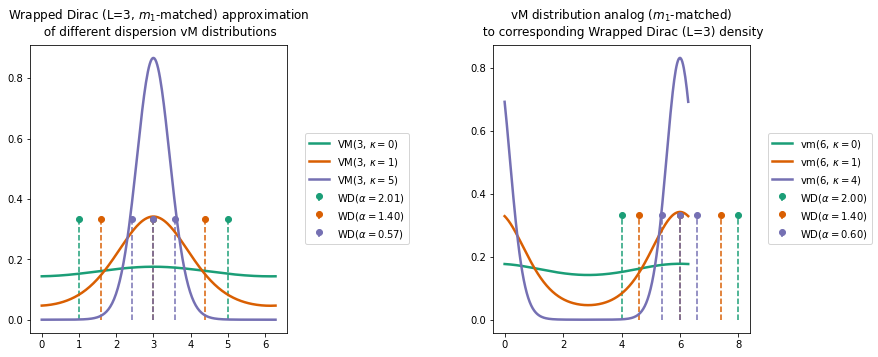

In [119]:
fig = plt.figure(figsize=(10,4))

# Approximate von Mises distributions with WD (L=3) m1-matched approximation
vm_mu = 3
vm_params_list = [(vm_mu, 1e-1), (vm_mu, 1), (vm_mu, 5)]

# -----------------------------------------------------------------------
angles = np.linspace(0, 2*np.pi, num=250)
cmap = mpl.cm.get_cmap('Dark2')

ax = fig.add_subplot(121)
for i, vm_params in enumerate(vm_params_list):
    (gammas, betas) = vmf_to_wd(vm_params)
    alpha = betas[1]-betas[0]
    
    ax.plot(angles, vonmises(vm_params[1], vm_params[0]).pdf(angles),
             lw = 2.5, c = cmap(i),
             label = r'VM(%d, $\kappa=$%d)'%(vm_params[0], vm_params[1]))
    
    # Draw Dirac approximations
    # NB: plt.stem does not allow all properties to be configurable via keyword arguments. Adapt the line objects returned by pyplot.
    markerline, stemlines, baseline = ax.stem(betas, gammas, label = r'WD($\alpha=$%.2f)'%alpha, use_line_collection = True)
    markerline.set_color(cmap(i))
    stemlines.set_color(cmap(i))
    stemlines.set_linestyles('--')
    baseline.set_color("None")

ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_title(r'Wrapped Dirac (L=3, $m_1$-matched) approximation' + '\n of different dispersion vM distributions', y=1.01);

# ===================================================================================================================================
# Convert WD mixture distribution to vM distribution with identical first moment
# Specifically, we will simulate WD (L=3) moment matched approximaion of von Mises
wd_mu = 6
alphas = [2.0, 1.4, 0.6]

# --------------------------------------------------------------------------
alphas = np.array(alphas)
gammas = np.ones(3)/3.
betas = wd_mu + np.outer(alphas, np.array([-1,0,1]))

wd_params_list = list(zip(gammas.repeat(alphas.size).reshape(-1,3), betas))

ax = fig.add_subplot(122)
for i, wd_params in enumerate(wd_params_list):
    (mu, kappa) = wd_to_vmf(wd_params)
    alpha = wd_params[1][1]-wd_params[1][0]
    
    # Draw WD distributions
    # NB: plt.stem does not allow all properties to be configurable via keyword arguments. Adapt the line objects returned by pyplot.
    markerline, stemlines, baseline = ax.stem(wd_params[1], wd_params[0], label = r'WD($\alpha=$%.2f)'%alpha, use_line_collection = True)
    markerline.set_color(cmap(i))
    stemlines.set_color(cmap(i))
    stemlines.set_linestyles('--')
    baseline.set_color("None")

    ax.plot(angles, vonmises(kappa, mu).pdf(angles),
             lw = 2.5, c = cmap(i),
             label = r'vm(%d, $\kappa=$%d)'%(mu, kappa))
    
    
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_title(r'vM distribution analog ($m_1$-matched)' + '\n to corresponding Wrapped Dirac (L=3) density', y=1.01)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.8)

# State update
Assume we have a system model that updates state $x_k$ to state $x_{k+1}$ with some additive noise $w_k \sim vM(\mu_{w_k}, \kappa_{w_k}$,
$$ x_{k+1} = a_k(x_k) + w_k$$

The transition density is given by
\begin{align*}
    f(x_{k+1}\mid x_k) &= \int_0^{2\pi} f(x_{k+1},\, w_k \mid x_k) \,\mathrm{d}w_k \\
        &= \int_0^{2\pi} f(x_{k+1} \mid x_k, \, w_k)\, f_w(w_k) \,\mathrm{d}w_k \\
        &= \int_0^{2\pi} \delta\big(x_{k+1} - (a_k(x_k) + w_k)\big)\, f_w\big(w_k\big) \,\mathrm{d}w_k \\
        &= f_w\big(x_{k+1} - a_k(x_k)\big)
\end{align*}

Then, the predicted density $f(x_{k+1})$ is given by the the Chapman-Kolmogorov equation as follows:
$$f_{x_{k+1}}(x_{k+1}) = \int_0^{2\pi} f(x_{k+1} \mid x_k)\, f_{x_k}(x_k) \,\mathrm{d}x_k$$

In the special case when $a_k(\cdot)$ is the identity function, i.e. $a_k(x_k) = x_k$, the predicted density is the convolution of the noise and prior estimated density evaluated at the new state,
\begin{align*}
    f(x_{k+1}) &= \int_0^{2\pi} f_w(x_{k+1} - x_k)\, f_{x_k}(x_k) \,\mathrm{d}x_k = \big(f_w \ast f_{x_k} \big)\big(x_{k+1}\big)
\end{align*}

When $a_k(\cdot)$ is not the identity function, one could attempt to find a solution by rearranging the order of integration,
\begin{align*}
    f_{x_{k+1}}(x_{k+1}) &= \int_0^{2\pi} f_w\big(x_{k+1} - a_k(x_k)\big)\, f_{x_k}\big(x_k\big) \,\mathrm{d}x_k \\
        &= \int_0^{2\pi} \Big[\int_0^{2\pi} \delta\big(x_{k+1} - (a_k(x_k) + w_k)\big)\, f_w\big(w_k\big) \,\mathrm{d}w_k \Big]\,
                        f_{x_k}\big(x_k\big) \,\mathrm{d}x_k \\
        &= \int_0^{2\pi} f_w\big(w_k\big) \Big[\int_0^{2\pi} \delta\big(x_{k+1} - (a_k(x_k) + w_k)\big)\,   
                        f_{x_k}\big(x_k\big) \,\mathrm{d}x_k\Big]\,\mathrm{d}w_k
\end{align*}

However, it is still clear that the nonlinear operation on $x_k$ can be a computationally intensive if directly computed. This motivates the use of a discrete approximation of the continuous density $f_{x_k}(x_k)$, in particular, a discrete approximation with a small number of samples. Since $f_{x_k}(x_k)$ is distributed according to a von Mises density, whose shape is strongly determined by its circular moments, a sampling approach that deterministically chooses samples that capture these circular moments can be taken. As described above, we will approximate the von Mises distribution with a wrapped Dirac (WD) mixture density with $L$ components with identical first moment,
$$ f_{VM}(x) \approx p_{WD}(x) = \sum_{i=1}^L \gamma_i \, \delta(x - \beta_i), \quad \textrm{where } m_1^{f_{VM}} = m_1^{p_{WD}}$$

Substituting this approximation into the expression above, we find that the predicted density takes a similar form as in the special identity system case and is convolution of the process noise with a (discrete approximation of the) prior estimated density:
\begin{align*}
    f_{x_{k+1}}(x_{k+1}) &= \int_0^{2\pi} f_w\big(w_k\big)
            \Big[\int_0^{2\pi} \delta\big(x_{k+1} - (a_k(x_k) + w_k)\big)\,   
                        f_{x_k}\big(x_k\big) \,\mathrm{d}x_k\Big]\,\mathrm{d}w_k \\
        &\approx \int_0^{2\pi} f_w\big(w_k\big)
            \Big[\int_0^{2\pi} \delta\big(x_{k+1} - (a_k(x_k) + w_k)\big)\,   
                        \sum_{i=1}^L \big( \gamma_i \, \delta(x - \beta_i) \,\mathrm{d}x_k\big)\Big]\,\mathrm{d}w_k \\
        &\quad= \int_0^{2\pi} f_w\big(w_k\big) \sum_{i=1}^L \gamma_i\,
            \Big[\int_0^{2\pi} \delta\big(x_{k+1} - (a_k(x_k) + w_k)\big)\,   
                        \delta(x - \beta_i) \,\mathrm{d}x_k\Big]\,\mathrm{d}w_k \\
        &\quad= \int_0^{2\pi} f_w\big(w_k\big) \sum_{i=1}^L \gamma_i\, \delta\big(x_{k+1} - (a_k(\beta_i) + w_k)\big) \,\mathrm{d}w_k \\
        &\quad= \int_0^{2\pi} f_w\big(w_k\big)\, p_{x_k}(x_{k+1}-w_k) \,\mathrm{d}w_k \\
        &\quad= \big(f_w \ast p_{x_k}\big)\big(x_{k+1}\big)
\end{align*}

In [142]:
def update_prediction(A, x_params, w_params):
    """
    Updates predicted distribution given additive angular noise
    Parameters
        A: 
           Function handle for system update equation, must be able to take scalar and/or array_like input
        x_params: (mu, kappa) tuple
            Parameters of predicted distribution on state given system model
        w_params: (mu, kappa) tuple
            Parameters of process noise distribution
    Returns
        x_1_params: (mu, kappa) tuple
            Parameters of estimated distribution of state x
    """
    
    # Approximate prior distribution on state with discrete approximation
    (gammas, betas) = vmf_to_wd(x_params)
    
    # Apply system function to discrete approximations
    betas_1 = A(betas)
    gammas_1 = gammas
    
    # Convert discrete p_{k+1}() to parameters of continuous f_{k+1}
    A_x_params = wd_to_vmf((gammas_1, betas_1))
    
    # Add in process noise
    return vmf_convolve(A_x_params, w_params)

When considering process noise, it may be more intuitive to think in terms of variance/dispersion rather than concentration. Recall that these two values of inversely related: low concentration indicates high variance, and high concentration indicates low variance.

**Row 1: $w \sim VM(0, \kappa = 2)$**

When the noise process is high variance/low concentration (for von Mises, a heuristic threshold between low/high concentration is around $\kappa = 5$),
the noise $w_k$ has non-zero probability of taking on a value far away from its mean, $\mu_{w_k}=0$.
Thus, the system state at $x_{k+1}$ can be greatly perturbed by process noise and the resulting predicted density.
Therefore, the predicted density $f_{x_{k+1}}$ also has a very dispersed.
Its mean also remains close to the mean of the prior distribution $f_{x_{k}}$, instead of evolving according to system function $\mu_{k+1} = A(\mu_k)$,
since again, the noise process likely dominates the update.

**Row 2: $w \sim VM(0, \kappa = 10)$**

As the variance of the noise process decreases, the concentration of our predicted increases and updates according to the system function.

**Row 3: $w \sim VM(0, \kappa = 20)$**

When the variance of the noise process is very low, the noise perturbation will be near the known mean of its distribution, and our system evolution function dominates the update.
The concentration of the predicted density is then limited by the concentration of the prior distribution, and the mean of the predicted density evolves according to the system function.

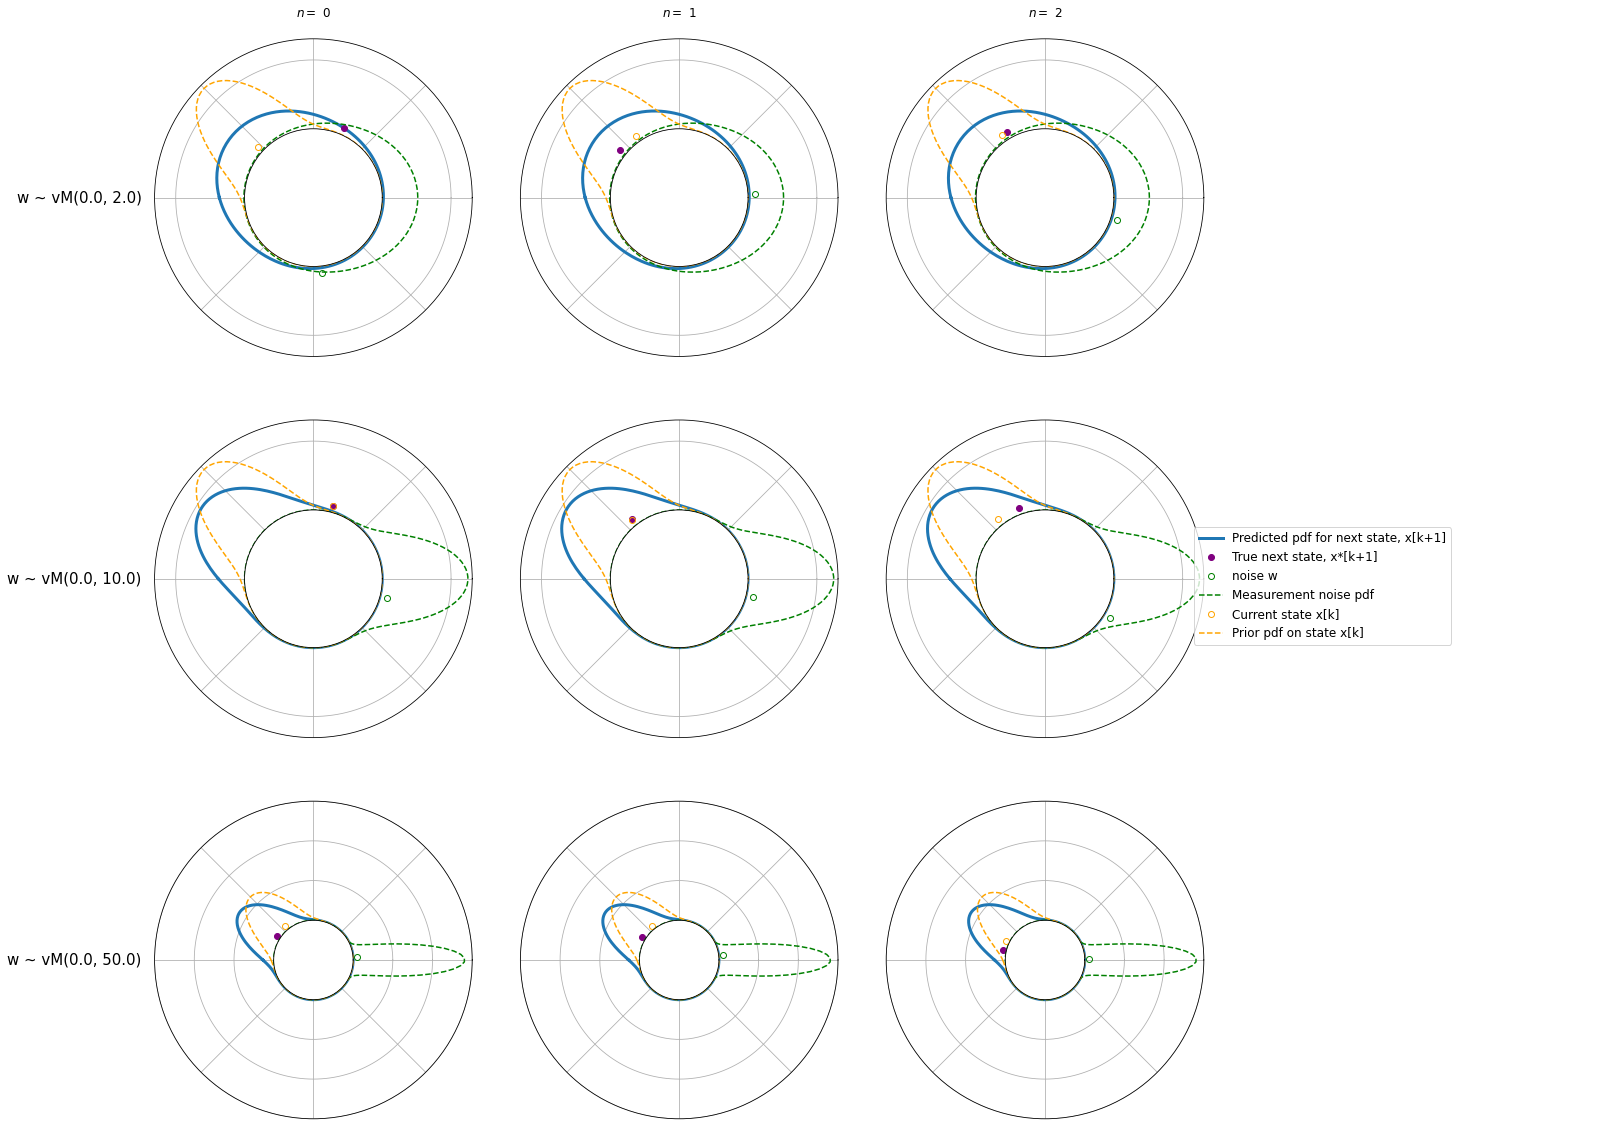

In [143]:
np.set_printoptions(precision=2)
p_params = (3*np.pi/4, 10)
w_params_list = [(0, 2), (0, 10), (0, 50)] # Assume identity system with zero noise

# -----------------------------------------------------------------------------------
def plot_prediction_update(x_params, w_params, ax, kwargs_list):
    X = vonmises(x_params[1], x_params[0]); W = vonmises(w_params[1], w_params[0])
    
    # KGH 2013 simulation example: Rotation system function for robot arm under gravity
    # Can take scalar or vector (d=1)
    A = lambda xs: xs + 0.1*np.sin(xs) + 0.15

    # True x_{k+1}: Update state and add noise
    x = X.rvs(1); w = W.rvs(1)
    x_1_true = A(x) + w
    
    # Predicted x_{k+1}
    x_1_params = update_prediction(A, x_params, w_params)
    X_1 = vonmises(x_1_params[1], x_1_params[0])

    # ------------------------------------------------------
    ax.plot(angles, X_1.pdf(angles), **kwargs_list[0])   # Plot predicted distribution
    ax.plot(x_1_true, 1e-1, **kwargs_list[1])            # Plot true noisy updated state
    
    ax.plot(w, 1e-1, **kwargs_list[2])                   # Plot noise distribution
    ax.plot(angles, W.pdf(angles), **kwargs_list[3])
    
    ax.plot(x, 1e-1, **kwargs_list[4])                   # Plot prior distribution and state
    ax.plot(angles, X.pdf(angles), **kwargs_list[5])
    
    ax.set_rorigin(-1); ax.set_rgrids(np.arange(0,ax.get_ylim()[-1]+0.2));
    ax.set_xticklabels(''); ax.set_yticklabels('')
    return ax

angles = np.linspace(-np.pi, np.pi, num=250)

r = len(w_params_list); c = 3
fig = plt.figure(figsize=(5*r,5*c))

# This order must match the order in which elements are plotted in plot_measurement_pdate(...)
kwargs_list = [{'color': 'C0',     'lw': 3,                                             'label': 'Predicted pdf for next state, x[k+1]'},
               {'color': 'purple', 'linestyle': 'None','marker': 'o',  'mfc': 'purple', 'label': 'True next state, x*[k+1]'},
               {'color': 'green',  'linestyle': 'None', 'marker': 'o', 'mfc': 'None',   'label': 'noise w'},
               {'color': 'green',  'linestyle': '--',                                   'label': 'Measurement noise pdf'},
               {'color': 'orange', 'linestyle': 'None', 'marker': 'o', 'mfc': 'None',   'label': 'Current state x[k]'},
               {'color': 'orange', 'linestyle': '--',                                   'label': 'Prior pdf on state x[k]'},
              ]

for i, w_params in enumerate(w_params_list):
    for j in range(3): # For each (p_params, v_params) pair, draw 3 sampled
        ax = fig.add_subplot(r, c, 3*i+j+1, projection='polar')
        ax = plot_prediction_update(p_params, w_params, ax, kwargs_list)
        
        if ax.is_first_col():    # Label rows by distribution
            row_label = 'w ~ vM(%.1f, %.1f)'%(w_params[0], w_params[1])
            ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points', size=15, ha='right', va='center')
        if ax.is_first_row():    # Label columns
            ax.set_title(r'$n=$ %d' %(j), size = 12, y=1.05)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.05) # Reduce whitespace
fig.legend([Line2D([0],[0], **kwargs) for kwargs in kwargs_list],
           [kwargs['label'] for kwargs in kwargs_list],
           loc='center left', bbox_to_anchor=[1.1,0.5], fontsize=12)

# Measurement update

Assume we have an observation model that observes the state $x_k$ with some additive noise $v_k \sim vM(\mu_{v_k}, \kappa_{v_k})$,
$$ z_k = x_k + v_k $$

The measurement likelihood function $f(z_k \mid x_k)$ is given by
\begin{align*}
    f(z_k \mid x_k) &= \int_0^{2\pi} f(z_k, v_k \mid x_k) \,\mathrm{d}v_k \\
        &= \int_0^{2\pi} f(z_k\mid x_k, v_k )\, f_v(v_k)  \,\mathrm{d}v_k \\
        &= \int_0^{2\pi} \delta(z_k - (x_k + v_k))\, f_v(v_k)  \,\mathrm{d}v_k \\
        &= f_v(z_k - x_k)
\end{align*}

Thus, our posterior distribution on $x_k$ given observation $z_k$ is,
\begin{align*}
    f_{x_k^+}(x_k \mid z_k)
        \propto f(z_k \mid x_k)\,f_{x_k^-}(x_k)
        = f_v(z_k - x_k)\,f_{x_k^-}(x_k)
\end{align*}
i.e. the prior/predicted distribution on $x_k$ multiplied by the distribution on 'expected' additive angular noise $z_k - x_k$.

In [79]:
def update_measurement(z, x_params, v_params):
    """
    Updates predicted distribution given additive angular noise
    Parameters
        z: scalar
            Observation of angular state x
        x_params: (mu, kappa) tuple
            Parameters of predicted distribution on state given system model
        v_params: (mu, kappa) tuple
            Parameters of observation noise distribution
    Returns
        e_params: (mu, kappa) tuple
            Parameters of estimated distribution of state x
    """
    
    # "Pre-shift" noise parameters by measurement
    vshift_params = ((z-v_params[0])%(2*np.pi), v_params[1])
    
    # Compute update: Multiply densities
    return vmf_multiply(x_params, vshift_params)

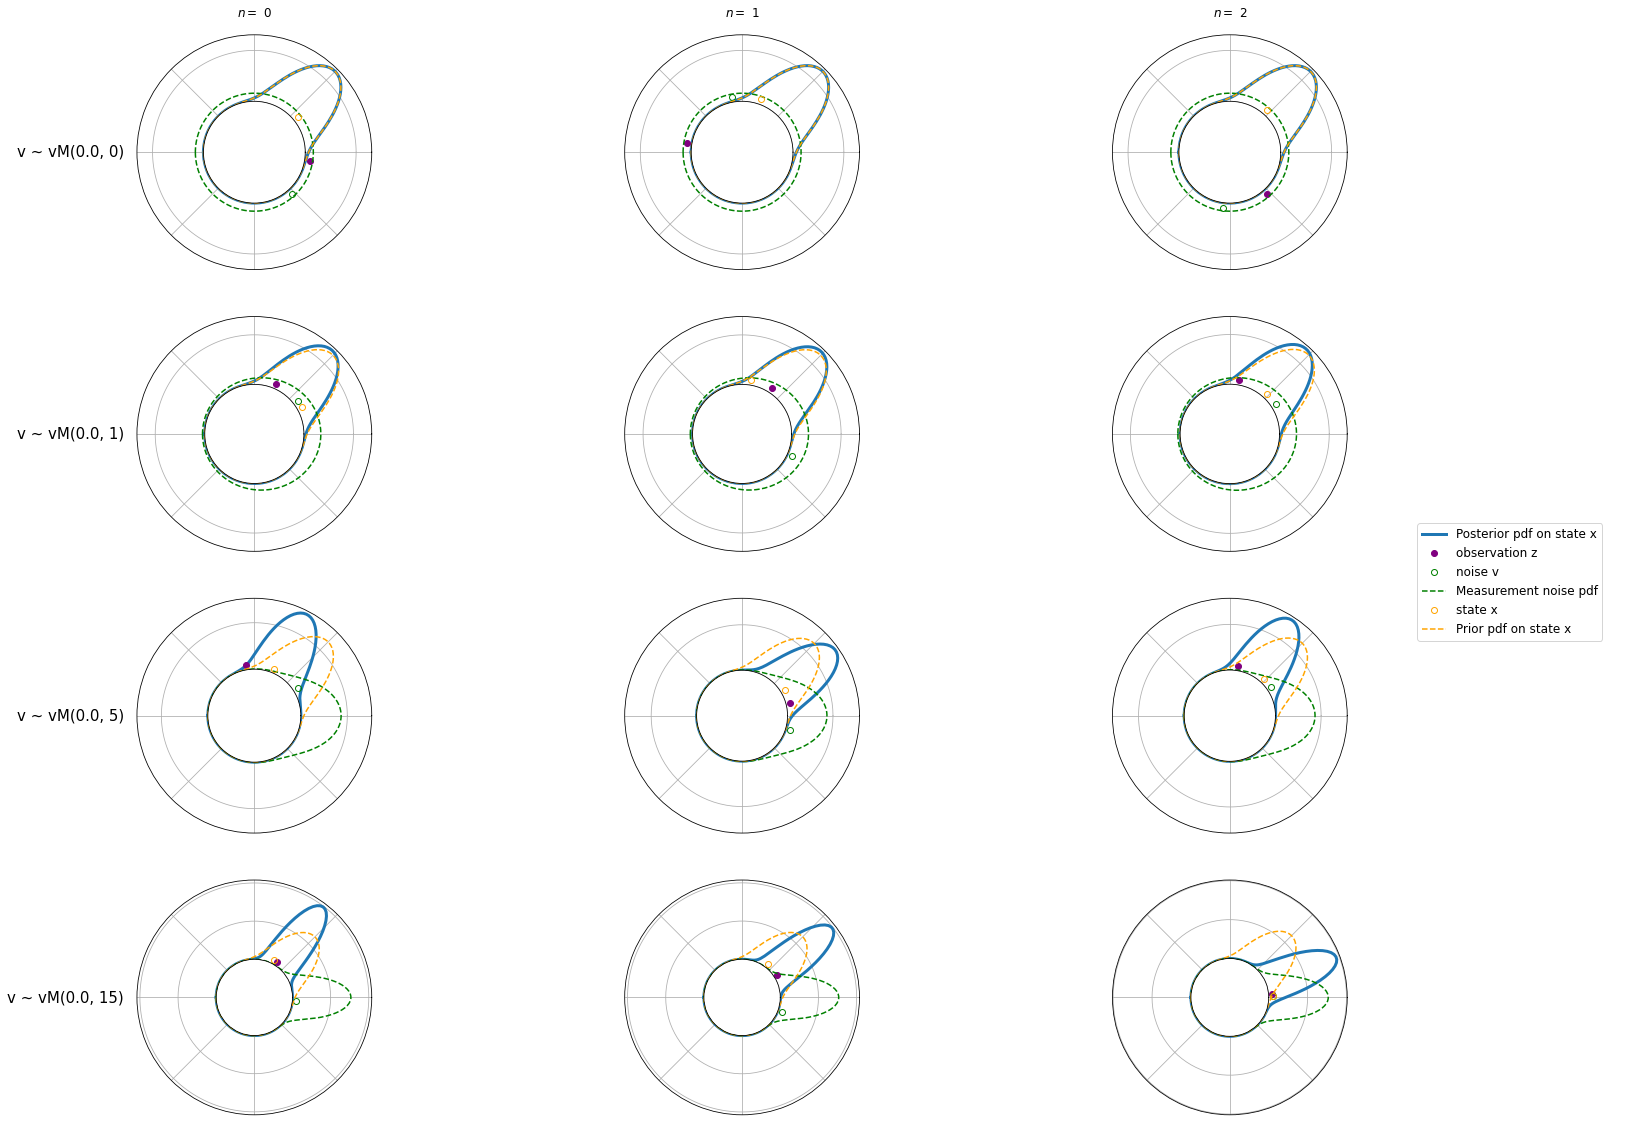

In [96]:
# Sketch three examples of updating prior distribution on state x ~ vM(p_params) with additive noise v ~ vM(v_params)

p_params = (np.pi/4, 10)
v_params_list = [(0, 1e-3), (0, 1), (0, 5), (0,15)] # Assume identity system with zero noise

# -----------------------------------------------------------------------------------
def plot_measurement_update(p_params, v_params, ax, kwargs_list):
    X = vonmises(p_params[1], p_params[0]); V = vonmises(v_params[1], v_params[0])
    
    # Make noisy observation: z = x + v
    x = X.rvs(1); v = V.rvs(1)
    z = x + v

    # Update distribution given observation
    e_params = update_measurement(z, p_params, v_params)
    E = vonmises(e_params[1], e_params[0])

    # ------------------------------------------------------
    ax.plot(angles, E.pdf(angles), **kwargs_list[0])   # Plot posterior distribution
    ax.plot(z, 1e-1, **kwargs_list[1])                 # Plot observation
    
    ax.plot(z-x, 1e-1, **kwargs_list[2])               # Plot noise distribution and sample
    ax.plot(angles, V.pdf(angles), **kwargs_list[3])
    
    ax.plot(x, 1e-1, **kwargs_list[4])                 # Plot prior distribution and state
    ax.plot(angles, X.pdf(angles), **kwargs_list[5])
    
    ax.set_rorigin(-1); ax.set_rgrids(np.arange(0,ax.get_ylim()[-1]+0.2))
    ax.set_xticklabels(''); ax.set_yticklabels('')
    return ax

angles = np.linspace(-np.pi, np.pi, num=250)

r = len(v_params_list); c = 3
fig = plt.figure(figsize=(5*r,5*c))

# This order must match the order in which elements are plotted in plot_measurement_pdate(...)
kwargs_list = [{'color': 'C0',     'lw': 3,                                             'label': 'Posterior pdf on state x'},
               {'color': 'purple', 'linestyle': 'None','marker': 'o',  'mfc': 'purple', 'label': 'observation z'},
               {'color': 'green',  'linestyle': 'None', 'marker': 'o', 'mfc': 'None',   'label': 'noise v'},
               {'color': 'green',  'linestyle': '--',                                   'label': 'Measurement noise pdf'},
               {'color': 'orange', 'linestyle': 'None', 'marker': 'o', 'mfc': 'None',   'label': 'state x'},
               {'color': 'orange', 'linestyle': '--',                                   'label': 'Prior pdf on state x'},
              ]

for i, v_params in enumerate(v_params_list):
    for j in range(3): # For each (p_params, v_params) pair, draw 3 sampled
        ax = fig.add_subplot(r, c, 3*i+j+1, projection='polar')
        ax = plot_measurement_update(p_params, v_params, ax, kwargs_list)
        
        if ax.is_first_col():    # Label rows by distribution
            row_label = 'v ~ vM(%.1f, %d)'%(v_params[0], v_params[1])
            ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points', size=15, ha='right', va='center')
        if ax.is_first_row():    # Label columns
            ax.set_title(r'$n=$ %d' %(j), size = 12, y=1.05)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.05) # Reduce whitespace
fig.legend([Line2D([0],[0], **kwargs) for kwargs in kwargs_list],
           [kwargs['label'] for kwargs in kwargs_list],
           loc='center left', bbox_to_anchor=[0.98,0.5], fontsize=12)

# Simulation
[KGH 2013] presents simulation results on the following example:
    A robot arm is moved by a single rotary joint. Since the robot arm is affected by gravity, the torque acting on the rotary joint depends on the current angle. The robot arm is observed by some sensor that is capable of measuring the absolute orientation. Our goal is to estimate the angle of the rotary joint.
    
Their system model consists of
$$
x_{k+1} = a_k(x_k) + w_k
$$
with system function $a_k(x_k) = x_k + c_1\,\sin(x_k) + c_2$ 
for empirically determined constants $c_1$ and $c_2$ related to force of gravity and arm velocity, respectively.

The measurement model is given by
$$z_k = x_k + v_k$$
where $z_k$ is the arm orientation measurement given by the sensor.
$w_k$ and $v_k$ are independent (WN-distributed) noise.

### Parameters
\begin{align*}
    c_1 &= 0.1; \quad c_2 = 0.15 &\\
    v_k &= WN(0, \sigma = 0.1) & \approx VM(0, \kappa = 10.52)\\
    w_k &= WN(0, \sigma = 0.1) & \approx VM(0, \kappa = 10.52)
\end{align*}

### Initial state
\begin{align*}
    \tilde{x}_0 &= 0 \\
    x_0 &= WN(3, \sigma = 2) & \approx VM(0, \kappa = 0.79)
\end{align*}


In [180]:
# Convert KGH 2013 simulation parameters (using WN distribution) to VM parameters

# Moment matching functions to convert between WN and VM distributions (assume p = 2)
def vm_to_wn(params):
    """
    Converts vM distribution with parameters param to wN distribution with identical first circular moments
    Input
        params: (mu, kappa)  tuple
            mu: array_like (..., p)
            kappa: scalar or array_like (...,)
    Returns
        params_wn : (mu, sigma2) tuple
            mu: array_like (..., p)
                mu = arg m1
            sigma2: scalar or array_like (...,)
                sigma^2 = -2 * log |m1|
    """
    m1 = vmf_moment(params, n=1)
    return(np.angle(m1)%(2*np.pi), -2*np.log(np.abs(m1)))

def wn_moment(params, n=1):
    """
    Calculates the nth circular moment of a vMF with parameters mu and kappa
    Input
        params: (mu, sigma2)  tuple
            mu: array_like (..., p-1)
                Mean angle, in radians
            sigma2: scalar or array_like (...,)
                Variance
        n: int
            nth circular moment to evaluate
    Returns
        m : complex number
            nth circular moment of vMF distribution
    """
    
    mu, sigma2 = params
    return np.exp(n*mu*1j - 0.5*(n**2)*sigma2)

def wn_to_vm(params):
    """
    Converts vM distribution with parameters param to wN distribution with identical first circular moments
    Input
        params : (mu, sigma2) tuple
            mu: array_like (..., p)
            sigma2: scalar or array_like (...,)
    Returns
        params_vm: (mu, kappa)  tuple
            mu: array_like (..., p)
                mu = arg m1
            kappa: scalar or array_like (...,)
                kappa = Ap_inv(|m1|)
    """
    m1 = wn_moment(params, n=1)
    return(np.angle(m1), Ap_inv(np.abs(m1), p=2))


W_params = wn_to_vm((0,0.1))
V_params = wn_to_vm((0,0.1))
X_0_params = wn_to_vm((3,2))

print('Process noise VM params: ', W_params)
print('Observation noise VM params: ', V_params)
print('Initial state VM params: ', X_0_params)

Process noise VM params:  (0.0, 10.523195212731308)
Observation noise VM params:  (0.0, 10.523195212731308)
Initial state VM params:  (3.0, 0.7920033327771574)


In [273]:
# KGH 2013 simulation example: Rotation system function for robot arm under gravity

def simulate_and_run(K=150):
    A = lambda xs: xs + 0.1*np.sin(xs) + 0.15
    arr = {'X_pred': np.empty(K, dtype=({'names': ['mu', 'kappa'], 'formats': ['float', 'float'],})),
           'X_obsv': np.empty(K, dtype=({'names': ['mu', 'kappa'], 'formats': ['float', 'float'],})), # Estimation stored as parameters
           'x_true': np.zeros(K),
           'w': np.empty(K), 'v': np.empty(K), 'z': np.empty(K),
          }

    arr['X_pred'][0] = X_0_params
    for k in range(K):
        # Run system
        arr['w'][k] = vonmises.rvs(W_params[1], W_params[0], 1)
        if k < K-1:
            arr['x_true'][k+1] = (A(arr['x_true'][k]) + arr['w'][k]) % (2*np.pi)

        # Make observation
        arr['v'][k] = vonmises.rvs(V_params[1], V_params[0], 1)
        arr['z'][k] = (arr['x_true'][k] + arr['v'][k]) % (2*np.pi)

        # --------------------------------------------------------
        # Now, do your thing!
        arr['X_obsv'][k] = update_measurement(arr['z'][k], arr['X_pred'][k], V_params)
        if k < K-1:
            arr['X_pred'][k+1] = update_prediction(A, arr['X_obsv'][k], W_params)
    
    return arr

num_runs = 100
arr_rmse = np.empty(num_runs)
for i in range(num_runs):
    arr = simulate_and_run()
    
    # Metrics ---------------------------------------
    # Circular standard deviation = sqrt(-2 log(rbar))
    nstdv = 2
    stdv = np.sqrt(-2*np.log(Ap(arr['X_obsv']['kappa'], p=2)))
    
    # Angular error
    angular_error = np.minimum(np.abs(arr['x_true']-arr['X_obsv']['mu']), 2*np.pi-np.abs(arr['x_true']-arr['X_obsv']['mu']))
    
    # Angular RMSE
    arr_rmse[i] = np.sqrt(np.mean(angular_error**2))

## Simulation Results

[KGH13] performed angular filtering on the system described above and compared their filter (which we will refer to as the WN-VMF filter) with an unscented Kalman filter (UKF) and a modified UKF. The UKF assumes all probabiity distributions are Gaussian and does not consider the periodicity of angular states. The modified UKF accounts for the periodicity of the angular states and enforces a modulo $2\pi$ after each prediction and update step.

As expected, the standard UKF had the worst performance because it is unable to handle the discontinuity at $2\pi$. The modified UKF and the WN-VMF filters both had low angular error, but the WN-VMF has much lower RMSE standard deviation. Their results are reproduced below.

<center><img src='kgh13-fig8-simulation_results.png' style='width: 1000px'><\center>
    
<center><img src='kgh13-fig9-angular_rmse.png' style='width: 500px'><\center>
    
The simulation results based on the angular filter implemented in this Jupyter notebook are provided below ("VM filter"). The angular RMSE is slightly larger than the reported results for the modified UKF and the WN-VM filter. This may be due to my modification of only using the von Mises distribution to represent the state. This is significant because while the von Mises and wrapped normal distributions are considered close approximations of each other, and they have nearly indistinguishable densities in the limiting cases of $\kappa$, they are most dissimilar in the moderate values of $\kappa \in [0.1, 10]$ [Kent 1976, "Distributions, Porcesses and Statistics on Spheres"]. This is the range in which our simulation is running. So, the increased angular RMSE may be due to the use of a non-identical circular distribution.

Text(0.5, 1.0, 'Angular RMSE for 100 runs')

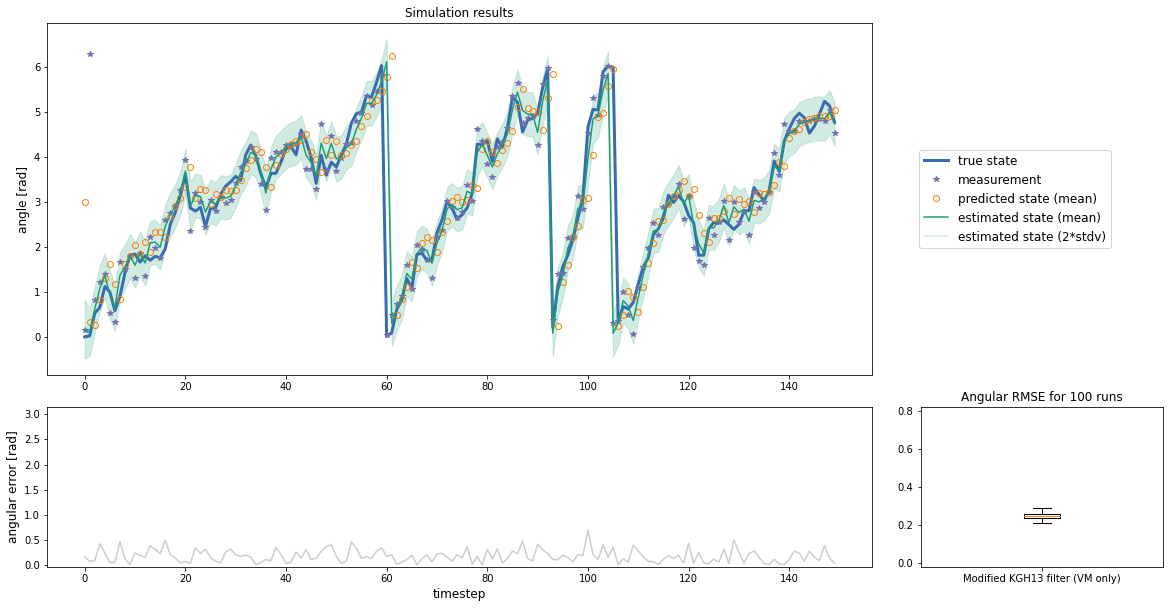

In [331]:
# Choosing qualitiatively distinct colors, from color brewer
lfmt = {'true': {'color': [ 56/255, 108/255, 176/255, 1], 'lw': 3, 'label': 'true state'},
        'z':    {'color': [117/255,112/255,179/255, 1], 'ls': 'None', 'label': 'measurement',
                'marker': '*', 'mfc': [117/255,112/255,179/255, 1],},
        'pred': {'color': [255/255, 127/255, 0/255, 1], 'ls': 'None', 'label': 'predicted state (mean)',
                'marker': 'o', 'mfc': 'None'},
        'obsv': {'color': [ 27/255, 158/255, 119/255, 1], 'ls': '-', 'label': 'estimated state (mean)',},
        'stdv': {'color': [ 27/255, 158/255, 119/255, 0.2], 'label': 'estimated state (%d*stdv)'%nstdv,}
       }

fig = plt.figure(figsize=(20,10))
gridspec.GridSpec(3,3, hspace = 0.8)

# Main results
ax = plt.subplot2grid((3,4), (0,0), colspan=3, rowspan=2)
ax.plot(arr['x_true'], **lfmt['true'])
ax.plot(arr['z'], **lfmt['z'])
ax.plot(arr['X_pred']['mu'], **lfmt['pred'])
ax.fill_between(np.arange(K), arr['X_obsv']['mu']-nstdv*stdv, arr['X_obsv']['mu']+nstdv*stdv, **lfmt['stdv'])
ax.plot(arr['X_obsv']['mu'], **lfmt['obsv'])

ax.set_ylabel('angle [rad]', fontsize=12)
ax.set_title('Simulation results')
ax.legend(handles = [Line2D([0],[0], **fmt) for fmt in lfmt.values()], loc ='center left', bbox_to_anchor=[1.05, 0.5],fontsize=12)

# Angular error
ax = plt.subplot2grid((3,4), (2,0), colspan=3, rowspan=1)
ax.plot(angular_error, color = [0.8,0.8,0.8])
ax.set_ylabel('angular error [rad]', fontsize=12)
ax.set_xlabel('timestep', fontsize=12)
ax.set_ylim([plt.ylim()[0], np.pi])

# Angular RMSE
ax = plt.subplot2grid((3,4), (2,3), colspan=3, rowspan=1)
ax.boxplot(arr_rmse)
ax.set_ylim([-0.02, 0.82])
ax.set_xticklabels(['Modified KGH13 filter (VM only)'])
ax.set_title('Angular RMSE for %d runs'%(num_runs))


## How observation $z_k$ updates predicted distribution

In the plots below, 5 timesteps are chosen at random. The pdf of the prior predited distribtuion $f_{x_k^-}$ is drawn in orange.
The true state $x_k$ is the unfilled star, and $z_k$ is the noisy measurement of $x_k$.

When the mean of the prior distribution, $\mu_{x_k^-}$ is close to the observation $z_k$, we see that the pdf of posterior distribution $f_{x_k^+}$ also remains centered around that angle and the larger concentration reflects the algorithms higher confidence in its estimate of the true state.

On the otherhand, when the mean of the prior distribution, $\mu_{x_k^-}$ is far from the observation $z_k$, we see that the pdf of posterior distribution $f_{x_k^+}$ shifts towards the observation. The weighting of predicted distribution versus observation is determined by our prior concentration parameter on the measurement noise distribution $V(\cdot)$.

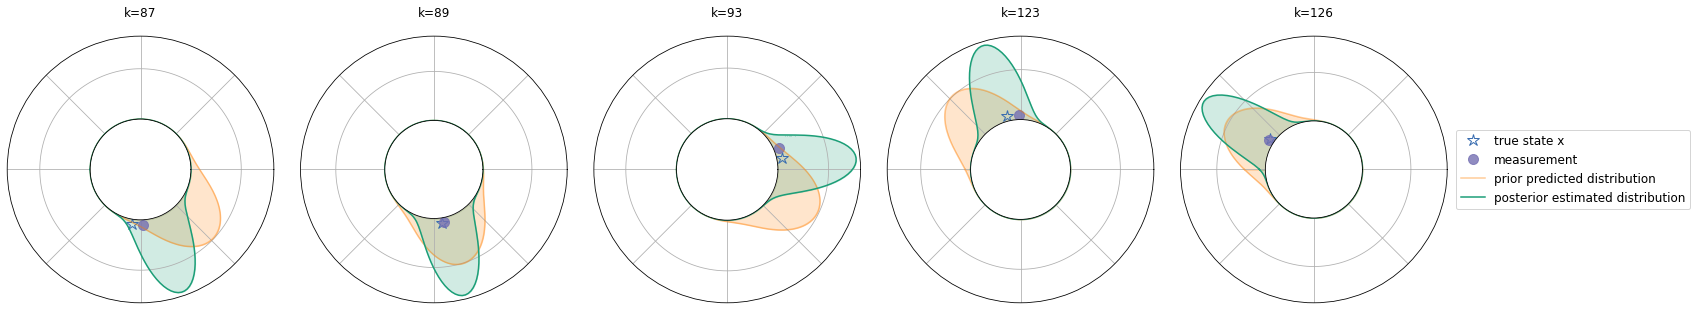

In [329]:
# Visualize how measurment updates predicted distribution

# -----------------------------------------------------------------------------------
def plot_simulation_update(arr, k, ax, lmft):
    predicted_params = arr['X_pred'][k]
    estimated_params = arr['X_obsv'][k]
    
    x = arr['x_true'][k]
    z = arr['z'][k]
    
    vmPred = vonmises(predicted_params[1], predicted_params[0])
    vmEstd = vonmises(estimated_params[1], estimated_params[0])

    # ------------------------------------------------------
    ax.plot(x, 1e-1, **lmft['x'])            
    ax.plot(z, 1e-1, **lmft['z'])
    ax.plot(angles, vmPred.pdf(angles), **lmft['pred'])   # Plot prior distribution
    ax.fill_between(angles, np.zeros_like(angles), vmPred.pdf(angles), **lfmt['pred'],alpha=0.2)
    
    ax.plot(angles, vmEstd.pdf(angles), **lmft['obsv'])   # Plot posterior distribution
    ax.fill_between(angles, np.zeros_like(angles), vmEstd.pdf(angles), **lfmt['obsv'],alpha=0.2)
    
    ax.set_rorigin(-1); ax.set_rgrids(np.arange(0,ax.get_ylim()[-1]+0.2))
    ax.set_xticklabels(''); ax.set_yticklabels('')
    return ax

lfmt = {'x': {'color': [56/255, 108/255, 176/255, 1], 'ls': 'None', 'label': 'true state x',
             'marker': '*', 'mfc': 'None', 'markersize': 12},
        'z':    {'color': [117/255,112/255,179/255, 1], 'ls': 'None', 'label': 'measurement',
                'marker': 'o', 'mfc': [117/255,112/255,179/255, 1], 'markersize': 10, 'alpha': 0.8},
        'pred': {'color': [255/255, 127/255, 0/255, 0.4], 'label': 'prior predicted distribution'},
        'obsv': {'color': [ 27/255, 158/255, 119/255, 1], 'label': 'posterior estimated distribution',},
       }

angles = np.linspace(-np.pi, np.pi, num=250)

r = 1; c = 5
fig = plt.figure(figsize=(20*r,10*c))

ks = np.sort(np.random.choice(np.arange(K), r*c, replace=False))

for i, k in enumerate(ks):
    ax = fig.add_subplot(r, c, i+1, projection='polar')
    ax.set_title('k=%d'%k)
    
    ax = plot_simulation_update(arr, k, ax, lfmt)
  

ax.legend(handles = [Line2D([0],[0], **fmt) for fmt in lfmt.values()],
           loc='center left', bbox_to_anchor=[1.01,0.5], fontsize=12)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.1) # Reduce whitespace